# Boto

In [1]:
receipt_path = '/Users/ankit/code/innovations_docs/hken_failed_receipts/IMG_7209.jpeg'

In [2]:
import boto3
import base64
client = boto3.client('textract')
with open(receipt_path, "rb") as image_file:
    file_content = base64.b64encode(image_file.read()).decode("utf-8")

# Extract file content from the event
file_content = base64.b64decode(file_content)
# Call Textract to analyze the document
response = client.analyze_expense(Document={'Bytes': file_content})
response

{'DocumentMetadata': {'Pages': 1},
 'ExpenseDocuments': [{'ExpenseIndex': 1,
   'SummaryFields': [{'Type': {'Text': 'INVOICE_RECEIPT_DATE',
      'Confidence': 99.97187805175781},
     'LabelDetection': {'Text': 'Date :',
      'Geometry': {'BoundingBox': {'Width': 0.07374904304742813,
        'Height': 0.015041577629745007,
        'Left': 0.08880540728569031,
        'Top': 0.27019456028938293},
       'Polygon': [{'X': 0.08880540728569031, 'Y': 0.2710268199443817},
        {'X': 0.16229721903800964, 'Y': 0.27019456028938293},
        {'X': 0.16255445778369904, 'Y': 0.28444546461105347},
        {'X': 0.08909580111503601, 'Y': 0.285236120223999}]},
      'Confidence': 66.34009552001953},
     'ValueDetection': {'Text': '22/07/2024',
      'Geometry': {'BoundingBox': {'Width': 0.15944090485572815,
        'Height': 0.0208289697766304,
        'Left': 0.18282261490821838,
        'Top': 0.26512619853019714},
       'Polygon': [{'X': 0.18282261490821838, 'Y': 0.26694807410240173},
     

# Lambda

In [3]:
import json
import base64
import boto3
from PIL import Image
import io

def _prepare_payload(image_path):
    with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return json.dumps({'file_content': encoded_string})


In [4]:
import os
from PIL import ExifTags, Image


def _preprocess_image(image_path):
    try:
        img = Image.open(image_path)
        try:
            exif = dict(img._getexif() or {})
        except AttributeError:
            exif = None

        current_size_bytes = os.path.getsize(image_path)
        print("_preprocess_image: size is {} exif = {}".format(current_size_bytes, len(exif)))
        max_size_bytes = 4.5 * 1024 * 1024

        if current_size_bytes > max_size_bytes:
            scaling_factor = (max_size_bytes / current_size_bytes) ** 0.5
            new_width = int(img.width * scaling_factor)
            new_height = int(img.height * scaling_factor)

            resized_img = img.resize((new_width, new_height))

            if exif and ExifTags.TAGS.get(274) in exif:
                orientation = exif[ExifTags.TAGS.get(274)]
                if orientation == 3:
                    resized_img = resized_img.rotate(180, expand=True)
                elif orientation == 6:
                    resized_img = resized_img.rotate(270, expand=True)
                elif orientation == 8:
                    resized_img = resized_img.rotate(90, expand=True)

            temp_output_path = os.path.join('resized', 'temp_output_image.jpg')
            print('<<<<<<<  resized_img called')
            if  exif:
                resized_img.save(temp_output_path, exif=img.info.get('exif'))
            else:
                resized_img.save(temp_output_path)
            return temp_output_path
        else:
            return image_path
    except Exception as e:
        print("An error occurred during image preprocessing: %s", e)
        raise



In [5]:
resized_image = _preprocess_image(receipt_path)
resized_image

_preprocess_image: size is 4971094 exif = 48
<<<<<<<  resized_img called


'resized/temp_output_image.jpg'

In [14]:
# Prepare payload
payload = _prepare_payload(resized_image)
print('payload')


payload


In [15]:
# Calculate the size of the payload in bytes
payload_size = len(payload.encode('utf-8'))  # Convert string to bytes and then get its length

print(f"Payload size: {payload_size} bytes")

MAX_PAYLOAD_SIZE = 6291456  # 6 MB in bytes
OCR_FUNCTION_NAME = 'ocr_analyze_expense_function'
if payload_size > MAX_PAYLOAD_SIZE:
    print("Payload is too large to send to Lambda.")
else:
    session = boto3.session.Session()
    # Invoke Lambda function
    response = session.client('lambda').invoke(
        FunctionName=OCR_FUNCTION_NAME,
        InvocationType='RequestResponse',
        Payload=payload
    )
    response_payload = json.loads(response['Payload'].read()).get('body', '{}')
    response_payload = json.loads(response_payload)
    

Payload size: 3093420 bytes


In [10]:
response_payload

{'DocumentMetadata': {'Pages': 1},
 'ExpenseDocuments': [{'ExpenseIndex': 1,
   'SummaryFields': [{'Type': {'Text': 'INVOICE_RECEIPT_DATE',
      'Confidence': 99.99259948730469},
     'LabelDetection': {'Text': 'Date',
      'Geometry': {'BoundingBox': {'Width': 0.06743510812520981,
        'Height': 0.014806042425334454,
        'Left': 0.0890030711889267,
        'Top': 0.270327627658844},
       'Polygon': [{'X': 0.0890030711889267, 'Y': 0.27091819047927856},
        {'X': 0.15620577335357666, 'Y': 0.270327627658844},
        {'X': 0.1564381867647171, 'Y': 0.28457775712013245},
        {'X': 0.0892627090215683, 'Y': 0.2851336598396301}]},
      'Confidence': 99.98788452148438},
     'ValueDetection': {'Text': '22/07/2024',
      'Geometry': {'BoundingBox': {'Width': 0.15905027091503143,
        'Height': 0.020454782992601395,
        'Left': 0.18313202261924744,
        'Top': 0.2653900682926178},
       'Polygon': [{'X': 0.18313202261924744, 'Y': 0.2668047547340393},
        {'X':

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ExifTags

def get_exif_orientation(image_path):
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        if exif_data:
            orientation = exif_data.get(274, 1)
            return orientation
    except Exception as e:
        print(f"Error reading EXIF data: {e}")
    return 1  # default orientation if no EXIF data or error

def rotate_image(image, orientation):
    if orientation == 1:
        return image
    elif orientation == 3:
        return image.transpose(Image.ROTATE_180)
    elif orientation == 6:
        return image.transpose(Image.ROTATE_270)
    elif orientation == 8:
        return image.transpose(Image.ROTATE_90)
    return image

def display_blocks_on_image(image_path, blocks):
    # Load and rotate image based on EXIF orientation
    orientation = get_exif_orientation(image_path)
    image = Image.open(image_path)
    rotated_image = rotate_image(image, orientation)
    
    # Convert rotated image to numpy array for matplotlib
    image_array = rotated_image.copy()
    
    # Display image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_array)
    plt.axis('off')
    
    # # Iterate over blocks and draw rectangles
    # for block in blocks:
    #     left, top, width, height = block.get_bounding_box(rotated_image.width, rotated_image.height)
    #     rect = Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
    #     plt.gca().add_patch(rect)
    
    plt.show()

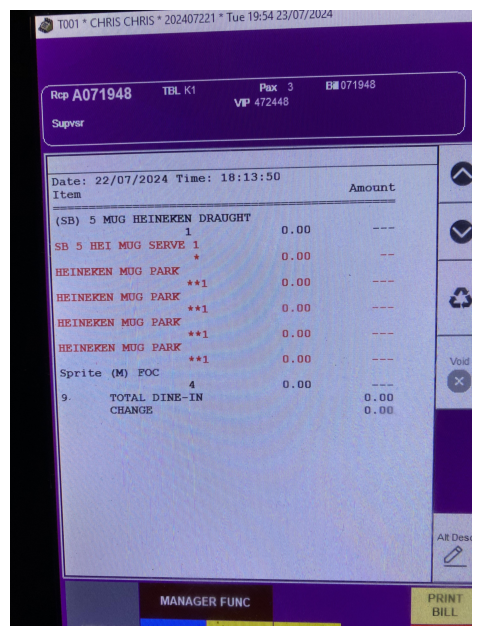

In [9]:
display_blocks_on_image(resized_image, response_payload)